#Customer Churn Prediction

In [219]:
import pandas as pd

df = pd.read_csv("dataset.csv")

df.head()

,customerID,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,DSL,No,Yes,No,No,Month-to-month,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,DSL,Yes,No,Yes,No,One year,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,DSL,Yes,Yes,No,No,Month-to-month,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,DSL,Yes,No,Yes,Yes,One year,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Fiber optic,No,No,No,No,Month-to-month,Electronic check,70.70,151.65,Yes


In [220]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   InternetService   7043 non-null   object 
 3   OnlineSecurity    7043 non-null   object 
 4   OnlineBackup      7043 non-null   object 
 5   DeviceProtection  7043 non-null   object 
 6   TechSupport       7043 non-null   object 
 7   Contract          7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   object 
 11  Churn             7043 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 660.4+ KB


In [221]:
df = df.drop(columns=["customerID"])

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df = df.dropna()

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            7032 non-null   int64  
 1   InternetService   7032 non-null   object 
 2   OnlineSecurity    7032 non-null   object 
 3   OnlineBackup      7032 non-null   object 
 4   DeviceProtection  7032 non-null   object 
 5   TechSupport       7032 non-null   object 
 6   Contract          7032 non-null   object 
 7   PaymentMethod     7032 non-null   object 
 8   MonthlyCharges    7032 non-null   float64
 9   TotalCharges      7032 non-null   float64
 10  Churn             7032 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 659.2+ KB


## Exploratory Data Analysis (EDA)

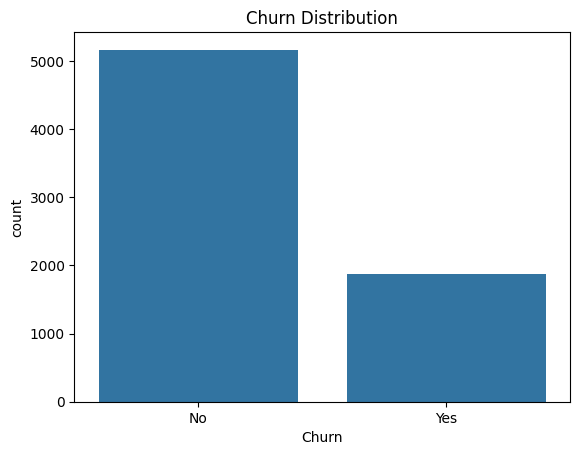

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

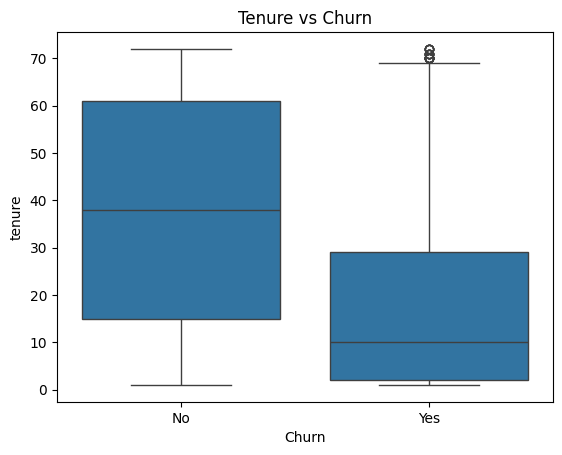

In [223]:
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.show()

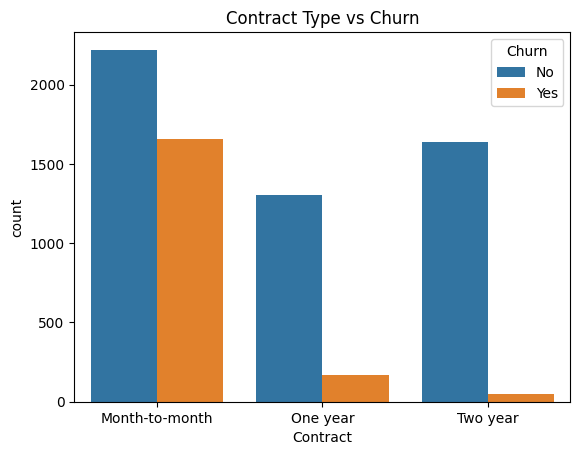

In [224]:
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract Type vs Churn")
plt.show()

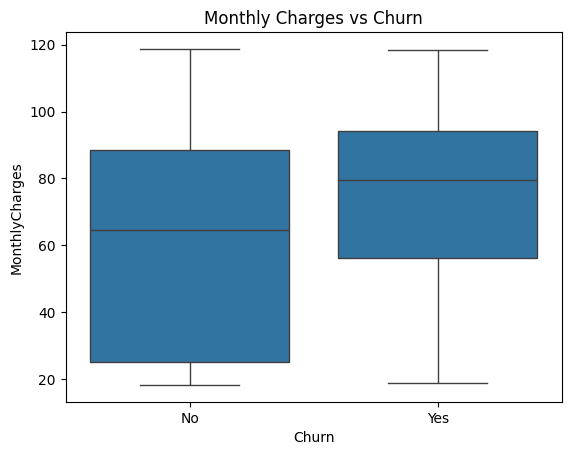

In [225]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

### EDA Insights
- Dataset is imbalanced toward non-churn customers
- Customers with shorter tenure churn more
- Month-to-month contracts have higher churn
- Higher monthly charges correlate with churn


In [226]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 5625
Testing samples: 1407


In [227]:
categorical_cols = X.select_dtypes(include="object").columns
categorical_cols

Index(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'Contract', 'PaymentMethod'],
      dtype='object')

In [228]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [229]:
y_encoded = y.map({"No": 0, "Yes": 1})

In [230]:
print(X_encoded.shape)
print(y_encoded.value_counts())

(7032, 18)
Churn
0    5163
1    1869
Name: count, dtype: int64


In [231]:
from sklearn.linear_model import LogisticRegression

In [232]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [233]:
model = LogisticRegression(max_iter=1000)

In [234]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [235]:
y_pred = model.predict(X_test)

In [236]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7889125799573561

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



## Feature Importance (Logistic Regression)

To understand which factors most strongly influence customer churn, we analyze the coefficients of the Logistic Regression model.
Positive coefficients indicate higher likelihood of churn, while negative coefficients indicate retention.

In [237]:
import pandas as pd

feature_names = X_encoded.columns

coefficients = model.coef_[0]

feature_importance_lr = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

feature_importance_lr["abs_coef"] = feature_importance_lr["Coefficient"].abs()
feature_importance_lr = feature_importance_lr.sort_values(
    by="abs_coef", ascending=False
)

feature_importance_lr.head(10)

,Feature,Coefficient,abs_coef
14,Contract_Two year,-1.464544,1.464544
13,Contract_One year,-0.801480,0.801480
6,OnlineSecurity_Yes,-0.552609,0.552609
3,InternetService_Fiber optic,0.525357,0.525357
12,TechSupport_Yes,-0.458778,0.458778
16,PaymentMethod_Electronic check,0.458081,0.458081
8,OnlineBackup_Yes,-0.235989,0.235989
9,DeviceProtection_No internet service,-0.207924,0.207924
11,TechSupport_No internet service,-0.207924,0.207924
4,InternetService_No,-0.207924,0.207924


/tmp/ipython-input-1216776084.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


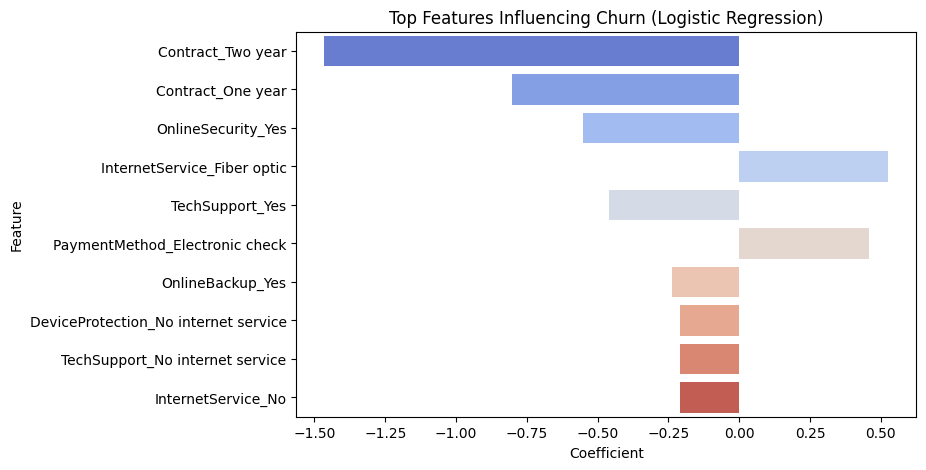

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt

top_features = feature_importance_lr.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Coefficient",
    y="Feature",
    data=top_features,
    palette="coolwarm"
)
plt.title("Top Features Influencing Churn (Logistic Regression)")
plt.show()

### Interpretation

Features such as contract type, tenure, and monthly charges have the strongest influence on churn.
Customers with month-to-month contracts and higher monthly charges are more likely to churn,
while longer tenure is associated with customer retention.

In [239]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [240]:
rf_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.7746979388770433

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1033
           1       0.60      0.47      0.53       374

    accuracy                           0.77      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.77      0.77      1407



## Feature Importance (Random Forest)

Random Forest provides feature importance based on how much each feature reduces impurity across decision trees.
This helps capture non-linear effects missed by Logistic Regression.

In [241]:
rf_importance = rf_model.feature_importances_

feature_importance_rf = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": rf_importance
}).sort_values(by="Importance", ascending=False)

feature_importance_rf.head(10)

,Feature,Importance
2,TotalCharges,0.235252
1,MonthlyCharges,0.215911
0,tenure,0.208361
14,Contract_Two year,0.061544
3,InternetService_Fiber optic,0.048144
16,PaymentMethod_Electronic check,0.036510
13,Contract_One year,0.029855
6,OnlineSecurity_Yes,0.026982
12,TechSupport_Yes,0.023165
8,OnlineBackup_Yes,0.021168


/tmp/ipython-input-275234894.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


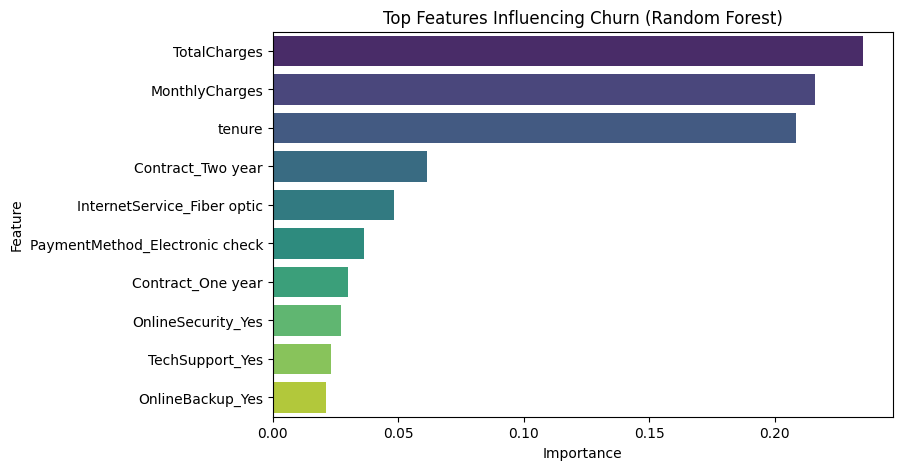

In [242]:
top_rf_features = feature_importance_rf.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Importance",
    y="Feature",
    data=top_rf_features,
    palette="viridis"
)
plt.title("Top Features Influencing Churn (Random Forest)")
plt.show()

### Interpretation

Random Forest confirms that contract type, tenure, and monthly charges are strong predictors of churn.
Additionally, service-related features such as tech support and online security show non-linear influence,
highlighting customer behavior patterns beyond linear relationships.

In [243]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [244]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel="rbf",
    class_weight="balanced",
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', random_state=42)

In [245]:
svm_pred = svm_model.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nSVM Classification Report:\n")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.7228144989339019

SVM Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



### Model Comparison Summary
Logistic Regression achieved the highest overall accuracy, while SVM showed superior recall for churned customers. Given the business objective of identifying potential churners, recall is a critical metric, making SVM particularly effective despite lower accuracy

##Neural Networks & Advanced Modeling

In [246]:
X_train_nn = X_train_scaled
X_test_nn = X_test_scaled

In [247]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42
)

nn_model.fit(X_train_nn, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

In [248]:
nn_pred = nn_model.predict(X_test_nn)

from sklearn.metrics import accuracy_score, classification_report

print("Neural Network Accuracy:", accuracy_score(y_test, nn_pred))
print("\nNeural Network Classification Report:\n")
print(classification_report(y_test, nn_pred))

Neural Network Accuracy: 0.767590618336887

Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.57      0.53      0.55       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.70      1407
weighted avg       0.76      0.77      0.76      1407



###Deep Learning Model

In [263]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [264]:
y_train_nn = y_train.values
y_test_nn = y_test.values

In [265]:
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [266]:
history = nn_model.fit(
    X_train_scaled,
    y_train_nn,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6873 - loss: 0.5582 - val_accuracy: 0.7920 - val_loss: 0.4301
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7924 - loss: 0.4409 - val_accuracy: 0.7964 - val_loss: 0.4249
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8038 - loss: 0.4321 - val_accuracy: 0.7956 - val_loss: 0.4239
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7939 - loss: 0.4298 - val_accuracy: 0.7973 - val_loss: 0.4211
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7946 - loss: 0.4314 - val_accuracy: 0.7973 - val_loss: 0.4211
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7944 - loss: 0.4431 - val_accuracy: 0.7956 - val_loss: 0.4207
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8054 - loss: 0.4194 - val_accuracy: 0.7991 - val_loss: 0.4232
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7985 - loss: 0.4288 - val_accuracy: 

In [267]:
loss, accuracy = nn_model.evaluate(X_test_scaled, y_test_nn, verbose=0)
print("Neural Network Accuracy:", accuracy)

Neural Network Accuracy: 0.7924662232398987


In [268]:
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test_nn, y_pred_nn))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



##Neural Network vs Classical Models
The neural network achieves comparable accuracy to Logistic Regression while slightly improving the F1-score for churn prediction. This indicates that for structured tabular data, classical models remain strong baselines, though neural networks can offer marginal gains when combined with proper scaling and tuning.

## Model Explainability (SHAP)

In [249]:
!pip install shap

In [269]:
import shap
import numpy as np

background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

In [270]:
explainer = shap.DeepExplainer(nn_model, background)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 18))']
  warnings.warn(msg)


In [271]:
shap_values = explainer.shap_values(X_test_scaled[:200])

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 18))']
  warnings.warn(msg)


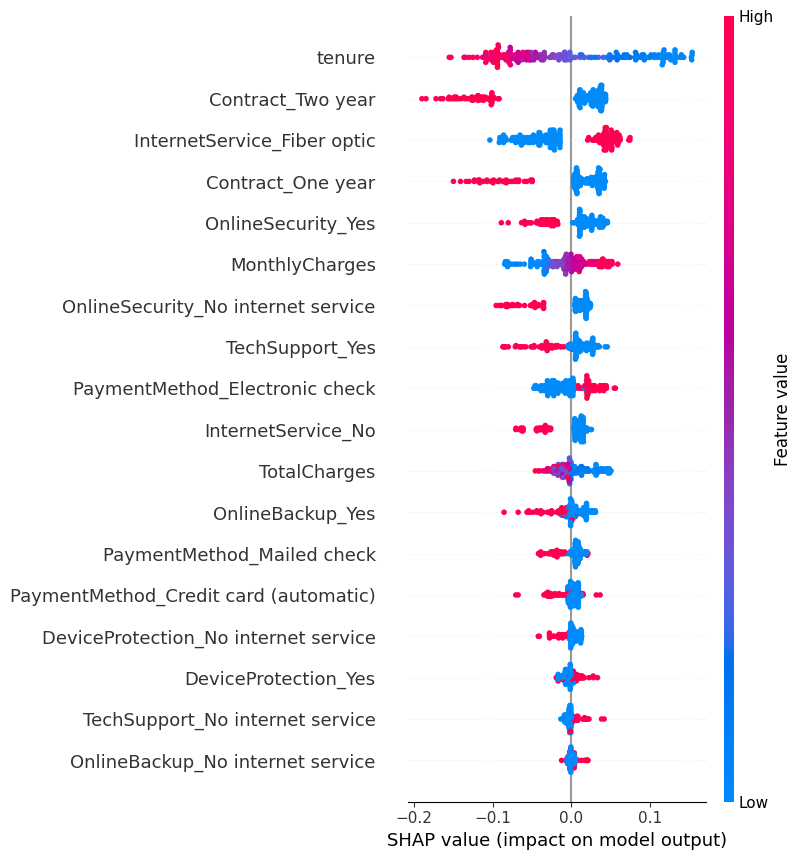

In [273]:
shap.summary_plot(
    shap_values[:, :, 0],
    X_test_scaled[:200],
    feature_names=X_encoded.columns
)